# Proyek Analisis Sentimen pada Review Sebuah Restoran

Tujuan dari proyek ini adalah untuk membuat sebuah model yang dapat memprediksi apakah review sebuah restoran merupakan review positif atau negatif. Proyek ini menggunakan [dataset yield](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set), dataset tersebut yang berisi kumpulan review terhap sebuah restoran.

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense#, LSTM, Bidirectional
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import json

## Mempersiapkan Dataset

In [2]:
df = pd.read_csv('yelp_labelled.txt', names=['sentence', 'label'], sep='\t')
df.head()

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Berdasarkan keterangan di atas diketahui bahwa dataset yang digunakan terdiri dari 1000 data dan tidak terdapat *missing value*.

## Preprocessing Data

### Mengubah seluruh text kedalam bentuk lowercase

In [4]:
df['sentence'] = df['sentence'].str.lower()

df.head()

,sentence,label
0,wow... loved this place.,1
1,crust is not good.,0
2,not tasty and the texture was just nasty.,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


### Menghilangkan [stopwords](https://en.wikipedia.org/wiki/Stop_word)

In [5]:
#nltk.download('stopwords')

In [6]:
stop_word = set(stopwords.words('english'))

df['sentence'] = df['sentence'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop_word)]))

df.head()

,sentence,label
0,wow... loved place.,1
1,crust good.,0
2,tasty texture nasty.,0
3,stopped late may bank holiday rick steve recom...,1
4,selection menu great prices.,1


### Melakukan split dataset

In [7]:
sentence = df['sentence'].values
label = df['label'].values

In [8]:
sentence_train, sentence_test, label_train, label_test = train_test_split(sentence, label, test_size=0.2, shuffle=False)

print('Training dataset:\n', sentence_train.shape, label_train.shape)
print('\nTest dataset:\n', sentence_test.shape, label_test.shape)

Training dataset:
 (800,) (800,)

Test dataset:
 (200,) (200,)


### Membuat tokenisasi

In [9]:
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ' # Untuk menghilangkan symbols

tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>", filters=filt)

tokenizer.fit_on_texts(sentence_train)

<>:1: SyntaxWarning: invalid escape sequence '\]'
<>:1: SyntaxWarning: invalid escape sequence '\]'
C:\Users\favia\AppData\Local\Temp\ipykernel_28612\1414076117.py:1: SyntaxWarning: invalid escape sequence '\]'
  filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ' # Untuk menghilangkan symbols


In [10]:
word_index = tokenizer.word_index
print(len(word_index))

1720


In [11]:
# Menyimpan word_index kedalam sebuah file json

with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)

### Membuat sequences dan melakukan padding

In [12]:
train_sekuens = tokenizer.texts_to_sequences(sentence_train)
test_sekuens = tokenizer.texts_to_sequences(sentence_test)


train_padded = pad_sequences(train_sekuens, 
                             maxlen=20,
                             padding='post',
                             truncating='post')
test_padded = pad_sequences(test_sekuens,
                            maxlen=20,
                            padding='post',
                            truncating='post')

In [13]:
train_padded.shape

(800, 20)

In [14]:
test_padded.shape

(200, 20)

## Membuat Model

In [15]:
model = tf.keras.Sequential([
    Embedding(2000, 20, input_length=20),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

c:\Users\favia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Melatih Model

In [17]:
num_epochs = 30
history = model.fit(train_padded, label_train, 
                    epochs=num_epochs, 
                    validation_data=(test_padded, label_test),
                    verbose=1)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5487 - loss: 0.6899 - val_accuracy: 0.2400 - val_loss: 0.7667
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5504 - loss: 0.6838 - val_accuracy: 0.2400 - val_loss: 0.7938
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5530 - loss: 0.6775 - val_accuracy: 0.2400 - val_loss: 0.7571
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5952 - loss: 0.6443 - val_accuracy: 0.4500 - val_loss: 0.6906
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7725 - loss: 0.5821 - val_accuracy: 0.5900 - val_loss: 0.6540
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8537 - loss: 0.4684 - val_accuracy: 0.4450 - val_loss: 0.7585
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9030 - loss: 0.3281 - val_accuracy: 0.8150 - val_loss: 0.4813
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9472 - loss: 0.2198 - val_accuracy: 0.7250 - val_loss

## Evaluasi Model

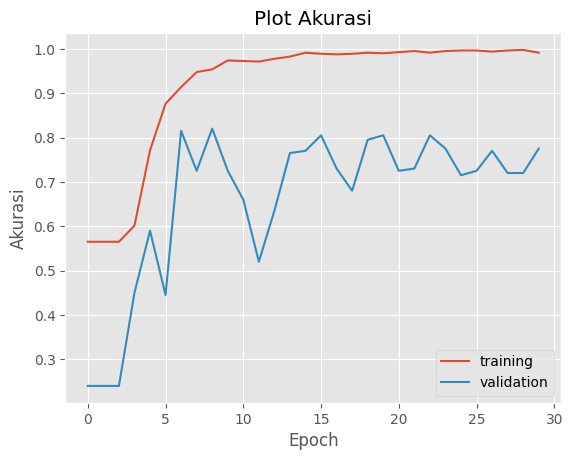

In [18]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="validation")
plt.title("Plot Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()
plt.savefig('images/plot_acc.png')
plt.show()

Berdasarkan plot tersebut dapat dilihat bahwa model yang digunakan masih sangat overfit 

## Save Model

In [19]:
model.save("model.h5")

## Convert Model

In [20]:
# Install tensorflowjs

!pip install tensorflowjs

     ---------------------------------------- 0.0/15.2 MB ? eta -:--:--
     -- ------------------------------------- 0.8/15.2 MB 8.5 MB/s eta 0:00:02
     ------ --------------------------------- 2.4/15.2 MB 10.3 MB/s eta 0:00:02
     ------------- -------------------------- 5.2/15.2 MB 11.4 MB/s eta 0:00:01
     ------------------ --------------------- 7.1/15.2 MB 9.7 MB/s eta 0:00:01
     ------------------------- -------------- 9.7/15.2 MB 10.2 MB/s eta 0:00:01
     -------------------------------- ------ 12.6/15.2 MB 11.1 MB/s eta 0:00:01
     ------------------------------------- - 14.7/15.2 MB 11.7 MB/s eta 0:00:01
     ------------------------------------- - 14.7/15.2 MB 11.7 MB/s eta 0:00:01
     ---------------------------------------- 15.2/15.2 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of tensorflow-decision-forests to determine which version is compa

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-server 2.27.3 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
jupyter-server 2.15.0 requires packaging>=22.0, but you have packaging 20.9 which is incompatible.
scikit-image 0.25.2 requires packaging>=21, but you have packaging 20.9 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-03-05 11:52:54.546754: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 11:52:55.393517: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
C:\Users\favia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflowjs\read_weights.py:28: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.uint8, np.uint16, np.object, np.bool]
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\favia\AppData\